In [1]:
import pandas as pd

/var/folders/l2/3rlb181n59v6czltkxgq_02m0000gn/T/ipykernel_22160/4080736814.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#### processing each book

## for 0:

def process_zero(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name']]
    df[['participant_name', 'name']] = df['name'].str.rsplit(' ', 1, expand=True)

    df = df.dropna()
    return df

## for 1: (Pinnacle)

def process_one(df):
    df = df.copy()
    df.dropna()
    return df[['handicap', 'odds', 'participant_name', 'name']]

## for two and six (DraftKings)

def process_two_six(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name']]

    df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
    df['participant_name'] = df['participant_name'].str.strip()

    df.dropna()

    return df

## for three and five

def process_three_five(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name', 'description']]

    df[['participant_name', 'description', 'a']] = df['description'].str.rsplit(' ', n=2, expand=True)
    df['participant_name'] = df['participant_name'].str.strip()

    df = df.drop(columns=['description', 'a'])
    df = df.dropna()

    return df


## for seven and eight

def process_seven_eight(df):
    df = df.copy()
    df = df[['handicap', 'odds', 'name']]

    df[['participant_name', 'name', 'a']] = df['name'].str.rsplit(' ', n=2, expand=True)

    df = df.drop(columns=['a'])
    df = df.dropna()

    return df

def process_master(data):
    df = pd.DataFrame.from_dict(data['market']['outcomes'])
    if data['bookie_key'] == "pinnacle":
        df = df.copy()
        df.dropna()
        df = df[['handicap', 'odds', 'participant_name', 'name']]
        return df
    # elif data['bookie_key'] == "fanduel":
    #     df = df.copy()
    #     df = df[['handicap', 'odds', 'name']]
    #     print(df)
    #     df[['participant_name', 'name']] = df['name'].str.rsplit(' ', 1, expand=True)

    #     df = df.dropna()
    #     return df
    elif data['bookie_key'] == "draftkings":
        df = df.copy()
        df = df[['handicap', 'odds', 'name']]

        df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
        df['participant_name'] = df['participant_name'].str.strip()

        df.dropna()
    
        return df
    elif data['bookie_key'] == "betrivers":
        df = df.copy()
        df = df[['handicap', 'odds', 'name']]

        df[['name', 'participant_name']] = df['name'].str.split(' - ', expand=True)
        df['participant_name'] = df['participant_name'].str.strip()

        df.dropna()

        return df

In [3]:
#### for merging all the books

## agg
def agg(df):    
    result_df = df.groupby(['participant_name', 'name']).agg({'handicap': 'first', 'odds': 'median'}).reset_index()
    return result_df

## pivot
def pivot(df):
    df = df.copy()
    pivot_df = pd.pivot_table(df, values='odds', index=['handicap', 'participant_name'], columns='name').reset_index()
    pivot_df.columns = ['line', 'participant_name', 'over_odds', 'under_odds']

    return pivot_df

## calculate odds
## adapted from Ammar Sulmanjee

def calculate_odds(x, y):
    if x >= 0:
        decimal_odds_1 = 1 + x/100
    else: 
        decimal_odds_1 = 1 + 100/abs(x)
        
    if y >= 0:
        decimal_odds_2 = 1 + y/100
    else: 
        decimal_odds_2 = 1 + 100/abs(y)

    imp_prob1 = (1 / decimal_odds_1) * 100
    imp_prob2 = (1 / decimal_odds_2) * 100

    total_implied_prob = round(imp_prob1 + imp_prob2, 4)
    fair_prob1 = round(imp_prob1 / total_implied_prob * 100, 2)
    fair_prob2 = round(imp_prob2 / total_implied_prob * 100, 2)

    ## 47, 53 == 100
    ## 53 - 50 = 3

    return max(fair_prob1, fair_prob2) - 50

In [4]:
bets = pd.DataFrame(columns = ['participant_name', 'ev', 'market', 'line'])

In [5]:
import os
import json

startdate = '2023-10-24'
enddate = '2024-01-26'

for d in pd.date_range(startdate, enddate):
    date = d.strftime("%Y-%m-%d")

    fantasy_directory = 'NBA_DATA/other/' + date
    bookies_directory = 'NBA_DATA/books/' + date
    
    if not os.path.exists(fantasy_directory):
        continue
    for market in os.listdir(fantasy_directory):
        if not os.path.exists(os.path.join(fantasy_directory, market)):
            continue
        for game in os.listdir(os.path.join(fantasy_directory, market)):
            #load the json file
            with open(os.path.join(fantasy_directory, market, game)) as f:
                data = json.load(f)
                # iterate over the data's "fantasy_books" subfield
                ud = None
                if 'fantasy_books' not in data:
                    continue
                for book in data['fantasy_books']:
                    if book['bookie_key'] == "prizepicks":
                        ud = pd.DataFrame.from_dict(book['market']['lines'])
                        ud = ud[['participant_name', 'line']]
                        ud.columns = [ud.columns[0], 'handicap']
                        

                        # get sportsbook odds
                        with open(os.path.join(bookies_directory, market, game.replace("fantasy", "books"))) as f:
                            bookies_data = json.load(f)
                            books = []
                            for bookie in bookies_data['sportsbooks']:
                                if bookie['bookie_key'] == "pinnacle" or bookie['bookie_key'] == "betrivers" or bookie['bookie_key'] == "draftkings":
                                    df = process_master(bookie)
                                    books.append(df)
                
                            # we need to concat the books

                            new_datasets = []
                            for dataset in books:
                                dataset = pd.merge(dataset, ud, how='inner', on = ['participant_name', 'handicap'])
                                dataset = agg(dataset)
                                if dataset.shape[0] > 0 and dataset.shape[1] > 0:
                                    new_datasets.append(pivot(dataset))
                            if new_datasets == []:
                                continue
                            concat = pd.concat(new_datasets, axis=0)
                            final = concat.copy()

                            # drop rows with null values
                            final = final.dropna()

                            final = final[final['over_odds'] >= -300]
                            final = final[final['over_odds'] <= 300]
                            final = final[final['under_odds'] >= -300]
                            final = final[final['under_odds'] <= 300]

                            final['ev']= final.apply(lambda row: calculate_odds(row['over_odds'], row['under_odds']), axis = 1)
                            final = final.drop(columns=['over_odds', 'under_odds'])

                            final = final.groupby(['participant_name', 'line']).agg({'ev': 'median'}).reset_index()

                            final = final[final['ev'] >= 4.99] # Minimum 5% edge
                            final = final[final['ev'] <= 25.00] #This is equivalent to dropping all odds whose absolute value are more than 300

                            final['market'] = market

                            final['game'] = game

                            final['date'] = date

                            if final.shape[0] > 0: bets = pd.concat([bets, final[['participant_name', 'ev', 'market', 'line', 'game', 'date']]])

bets = bets.sort_values(by=['date', 'ev'], ascending=False)
bets.dropna(inplace=True)
bets.drop_duplicates(keep='first', inplace=True, ignore_index=True)
bets.to_csv('Prizepicks_NBA_DATA_bets.csv', index=False)



/var/folders/l2/3rlb181n59v6czltkxgq_02m0000gn/T/ipykernel_22160/3219484881.py:77: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  if final.shape[0] > 0: bets = pd.concat([bets, final[['participant_name', 'ev', 'market', 'line', 'game', 'date']]])


In [8]:
bets = pd.read_csv('Prizepicks_NBA_DATA_bets.csv')

count     90.000000
mean      60.055556
std       27.467391
min       12.000000
25%       40.000000
50%       58.000000
75%       79.750000
max      124.000000
dtype: float64


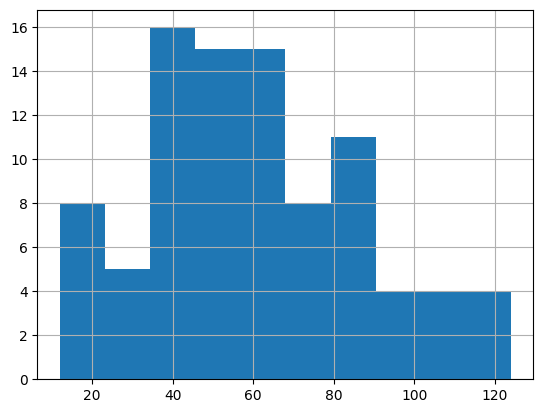

In [9]:
# Now, we will analyze the bets

# Count the number of bets per day
bets_per_day = bets.groupby('date').size()

# Show the five number summary of the number of bets per day
print(bets_per_day.describe())

# Show the distribution of bets per day in a line plot where the x-axis is the number of bets and the y-axis is the number of days with those many bets
import matplotlib.pyplot as plt
bets_per_day.hist()
plt.show()

date
2023-10-24    9.8600
2023-10-25    7.8525
2023-10-26    6.6300
2023-10-27    7.6900
2023-10-28    8.3500
               ...  
2024-01-22    8.6200
2024-01-23    8.3800
2024-01-24    6.8050
2024-01-25    7.0700
2024-01-26    8.3625
Name: ev, Length: 90, dtype: float64
count    90.000000
mean      7.987361
std       0.854127
min       6.630000
25%       7.407500
50%       8.037500
75%       8.350000
max      11.765000
Name: ev, dtype: float64


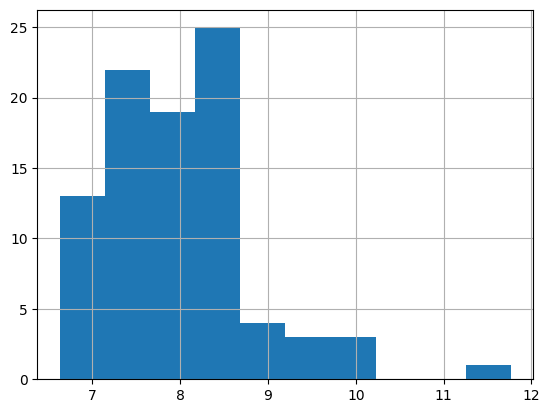

In [10]:
median_ev_per_day = bets.groupby('date')['ev'].median()
print(median_ev_per_day)

# Show the five number summary of the median EV per day
print(median_ev_per_day.describe())

# Show the distribution of median EV per day in a line plot where the x-axis is the median EV and the y-axis is the number of days with that median EV
import matplotlib.pyplot as plt
median_ev_per_day.hist()
plt.show()

market
player_rebounds_over_under                   999
player_points_over_under                     888
player_assists_rebounds_over_under           709
player_blocks_steals_over_under              657
player_assists_over_under                    522
player_threes_over_under                     445
player_steals_over_under                     299
player_assists_points_over_under             298
player_points_rebounds_over_under            229
player_blocks_over_under                     182
player_assists_points_rebounds_over_under    177
Name: count, dtype: int64


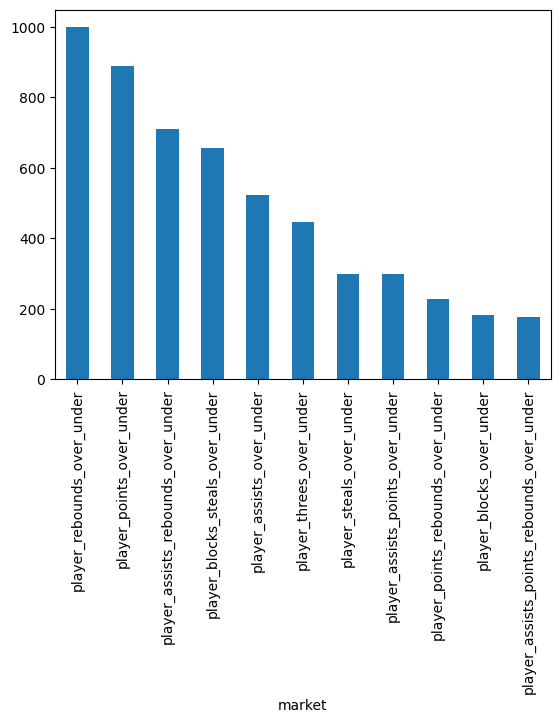

In [11]:
bets_per_market = bets['market'].value_counts()
print(bets_per_market)

# Graph the bets per market in a bar chart
import matplotlib.pyplot as plt
bets_per_market.plot.bar()
plt.show()

In [12]:
# We will find the number of potentially fake bets
# We say that a bet is fake if the edge over the house is greater than 10%
fake_bets = bets[bets['ev'] >= 10]
print(fake_bets)

real_bets = bets[bets['ev'] < 10]
print(real_bets)

# Show the size differences between the real and fake bets
print(fake_bets.shape)
print(real_bets.shape)

       participant_name      ev                           market  line  \
0           Luka Doncic  22.380         player_points_over_under  37.5   
1        Jordan Hawkins  21.450         player_points_over_under  10.5   
2      Kenrich Williams  20.260  player_blocks_steals_over_under   0.5   
3           Brook Lopez  19.300         player_steals_over_under   0.5   
4     Jaren Jackson Jr.  18.115         player_points_over_under  25.5   
...                 ...     ...                              ...   ...   
5392        Dario Saric  17.180         player_threes_over_under   0.5   
5393   D'Angelo Russell  14.130         player_threes_over_under   2.5   
5394  Spencer Dinwiddie  12.940         player_points_over_under  18.5   
5395       Jusuf Nurkic  11.130        player_assists_over_under   2.5   
5396       Jamal Murray  10.010         player_threes_over_under   2.5   

                                                   game        date  
0     fantasy__2024-01-26__3f46796f90363f